Imports
======

In [160]:
import numpy as np
import random
from numpy import sin, cos, sqrt, pi, exp
from numpy.random import rand, randint, uniform
from matplotlib import pyplot as plt

Objective Functions
======

In [161]:
def F1(var):
    #-pi<=x1, x2 <=pi
    ival=[-pi,pi]
    x1=var[0]; x2=var[1];
    
    A1=0.5*sin(1)-2*cos(1)+sin(2)-1.5*cos(2)
    A2=1.5*sin(1)-cos(1)+2*sin(2)-0.5*cos(2)
    B1=0.5*sin(x1)-2*cos(x1)+sin(x2)-1.5*cos(x2)
    B2=1.5*sin(x1)-cos(x1)+2*sin(x2)-0.5*cos(x2)
    
    f1=1+(A1-B1)**2+(A2-B2)**2
    f2=(x1+3)**2+(x2+1)**2
    fv=np.array([f1,f2])
    
    return fv, ival

def F2(var):
    #-3<=x1, x2 <=3
    ival=[-3,3]
    x1=var[0]; x2=var[1];
    
    f1=0.5*(x1**2+x2**2)+sin(x1**2+x2**2)
    f2=(3*x1-2*x2+4)**2/8+(x1-x2+1)**2/27+15
    f3=1/(x1**2+x2**2+1)-1.1*exp(-(x1**2+x2**2))
    fv=np.array([f1,f2,f3])
    
    return fv, ival

Functions
======

Core Functions
----

In [162]:
class pop:
    
    def  __init__(self,name,value):
        self.name=name
        self.value=value

        
class PPA:
    
    def  __init__(self,sz,pv,pm,ival,preds,preys_pref,f,xover,mutate):
        self.lattice=np.zeros((sz,sz)).astype(int).tolist()
        self.sz=sz
        self.pv=pv
        self.pm=pm
        self.ival=ival
        self.preds=preds
        self.pf=preys_pref
        self.f=f
        self.xover=xover
        self.mutate=mutate
        
    def distrib(self,pop):
        for i in pop:
            r=randint(0,self.sz,2)
            while(self.lattice[r[0]][r[1]]!=0):
                r=randint(0,self.sz,2)
            self.lattice[r[0]][r[1]]=i
            
    def vis(self):
        
        idx=np.nonzero(self.lattice)
        sz=self.sz
        preys=[[idx[0][i],idx[1][i]] for i in range(len(idx[0])) if self.lattice[idx[0][i]][idx[1][i]]!=0 and self.lattice[idx[0][i]][idx[1][i]].name=="prey"]
        preds=[[idx[0][i],idx[1][i]] for i in range(len(idx[0])) if self.lattice[idx[0][i]][idx[1][i]]!=0 and self.lattice[idx[0][i]][idx[1][i]].name=="pred"]
        preys=np.asarray(preys)
        preds=np.asarray(preds)

        plt.figure(figsize=(7,7))
        plt.imshow(np.zeros((sz,sz)),cmap=plt.cm.Greys)
        ax=plt.gca()
        ax.grid(color='k', linestyle='-', linewidth=2)
        ax.set_xticks(np.arange(-0.5, sz, 1))
        ax.set_yticks(np.arange(-0.5, sz, 1))
        ax.set_xticklabels(np.arange(0,sz, 1))
        ax.set_yticklabels(np.arange(0, sz, 1))

        plt.scatter(preys[:,0],preys[:,1],color='b',label="preys")
        plt.scatter(preds[:,0],preds[:,1],color='r',label="preds")

        plt.legend()
        plt.show()
        
    def move(self,name):
        idx=np.nonzero(self.lattice)
        sz=self.sz
        n=len(idx[0])
        prob=rand(n)
        for i in range(n):
            cell=self.lattice[idx[0][i]][idx[1][i]]
            if cell.name==name and prob[i]<=self.pv:
                count=0; m=[0,0]; j=0; k=0;
                while((self.lattice[j][k]!=0 or (m[0]==0 and m[1]==0)) and count!=10):
                    m=randint(-1,2,2)
                    j=sz-1 if (idx[0][i]==0 and m[0]==-1) else 0 if (idx[0][i]==sz-1 and m[0]==1) else idx[0][i]+m[0]
                    k=sz-1 if (idx[1][i]==0 and m[1]==-1) else 0 if (idx[1][i]==sz-1 and m[1]==1) else idx[1][i]+m[1]
                    count+=1
                if count==10 and self.lattice[j][k]!=0:
                    continue
                self.lattice[j][k]=cell
                self.lattice[idx[0][i]][idx[1][i]]=0
        
    def breed(self):
        idx=np.nonzero(self.lattice)
        sz=self.sz
        n=len(idx[0])
        m=[-1,0,1]
        for i in range(n):
            p1=self.lattice[idx[0][i]][idx[1][i]]
            if p1.name=="prey":
                nbhd=[]
                for r in m:
                    for c in m:
                        if not(r==0 and c==0):
                            j=sz-1 if idx[0][i]==0 and r==-1 else 0 if idx[0][i]==sz-1 and r==1 else idx[0][i]+r
                            k=sz-1 if idx[1][i]==0 and c==-1 else 0 if idx[1][i]==sz-1 and c==1 else idx[1][i]+c
                            nbhd.append(self.lattice[j][k])
                nbhd=[nb for nb in nbhd if nb!=0 and nb.name=="prey"]
                if nbhd:
                    p2=random.sample(nbhd,1)[0]
                    ch=self.xover(np.array([p1.value,p2.value])) #need the 2nd xover operator to produce the 2nd half of the pop
                    ch=self.mutate(ch,self.pm,self.ival)[0,:]
                    print(ch)
                    ch=pop("prey",ch)
                    rn=randint(0,sz,2); count=0;
                    while(self.lattice[rn[0]][rn[1]]!=0 and count!=10):
                        rn=randint(0,sz,2)
                        count+=1
                    if count==10 and self.lattice[rn[0]][rn[1]]!=0:
                        continue
                    self.lattice[rn[0]][rn[1]]=ch
        
    def kill(self):
        idx=np.nonzero(self.lattice)
        sz=self.sz
        n=len(idx[0])
        pn=sum([1 for i in range(n) if self.lattice[idx[0][i]][idx[1][i]].name=="prey"])

        T=int(np.floor((pn-self.pf)/self.preds))
        for t in range(T):
            idx=np.nonzero(self.lattice)
            n=len(idx[0])
            m=[-1,0,1]
            for i in range(n):
                cell=self.lattice[idx[0][i]][idx[1][i]]
                if cell!=0 and cell.name=="pred":
                    nbhd=[]; idcs=[];
                    for r in m:
                        for c in m:
                            if not(r==0 and c==0):
                                j=sz-1 if idx[0][i]==0 and r==-1 else 0 if idx[0][i]==sz-1 and r==1 else idx[0][i]+r
                                k=sz-1 if idx[1][i]==0 and c==-1 else 0 if idx[1][i]==sz-1 and c==1 else idx[1][i]+c
                                if self.lattice[j][k]!=0 and self.lattice[j][k].name=="prey":
                                    nbhd.append(self.lattice[j][k])
                                    idcs.append([j,k])
                    if nbhd:
                        fitness=[np.sum(self.f(i.value)[0]*cell.value) for i in nbhd]
                        lf=np.argmin(fitness)
                        idx2=idcs[lf]
                        self.lattice[idx2[0]][idx2[1]]=cell
                        self.lattice[idx[0][i]][idx[1][i]]=0
                    else:
                        self.move("pred")
    
    def pareto(self):
        
        idx=np.nonzero(self.lattice)
        pareto_v=np.asarray([self.lattice[idx[0][i]][idx[1][i]].value for i in range(len(idx[0])) if self.lattice[idx[0][i]][idx[1][i]]!=0 and self.lattice[idx[0][i]][idx[1][i]].name=="prey"])
        pareto_f=np.asarray([f(i)[0] for i in pareto_v])
        
        plt.figure(figsize=(7,7))
        plt.scatter(pareto_f[:,0],pareto_f[:,1],color='b')
        plt.show()
        
        return pareto_v, pareto_f


Variation Operators
---

In [163]:
def mutate_diff(pop,F=0.7): #differential mutation
    r=np.asarray([random.sample(list(range(0,i))+list(range(i+1,pop.shape[0])),3) for i in range(pop.shape[0])])
    pop_mu=np.asarray([pop[r[i,0],:]+F*(pop[r[i,1],:]-pop[r[i,2],:]) for i in range(pop.shape[0])])
    return pop_mu

def mutate_replace(pop,pm,ival):
    """ replaces a gene in a chromosome with another floating point 
    number randomly chosen within the bounds of the parameter values"""
    prob=rand(pop.shape[0])
    gene=[randint(pop.shape[1]) for i in prob if i<pm] #choosing genes (gene indicies) to replace
    gene_mu=uniform(ival[0],ival[1],len(gene)) #the replacements
    for i in range(len(gene)):
        pop[np.where(prob<pm)[0][i],gene[i]]=gene_mu[i]
    return pop

def xover_1pt(pop,pc=1):
    """1 point xover by swapping tails after crossover point"""
    sz=pop.shape; n=int(np.round(sz[0]/2)); L=sz[1];
#     prob=rand(n)
    cop=(np.round(rand(n)*(L-1))+1).astype(int) #random crossover points generation
    for i in range(n):
#         if prob[i]<pc:
        p1=pop[2*i,:] #parent 1
        p2=pop[0,:] if i==n-1 else pop[2*i+1,:] #parent 2
        t=p1[cop[i]:]
        p1[cop[i]:]=p2[cop[i]:]
        p2[cop[i]:]=t
        pop[2*i,:]=p1
        if i==n-1:
            pop[0,:]=p2
        else:
            pop[2*i+1,:]=p2
    return pop

def xover_uniform(pop,pc=1):
    sz=pop.shape; n=int(np.round(sz[0]/2)); L=sz[1];
#     prob=rand(n)
    for i in range(n):
#         if prob[i]<pc:            
        p1=pop[2*i,:] #parent 1
        p2=pop[0,:] if i==n-1 else pop[2*i+1,:] #parent 2
        c1=np.zeros(len(p1))
        c2=np.zeros(len(p2))
        coin=(np.round(rand(L))).astype(int)
        for j in range(L):
            c1[j]=p1[j] if coin[j]==1 else p2[j]
            c2[j]=p2[j] if coin[j]==1 else p1[j]
        pop[2*i,:]=c1
        pop[2*i+1,:]=c2
            
    return pop

def xover_blx(pop,alpha=0.5):
    """BLX-alpha crossover"""
    n=int(np.round(pop.shape[0]/2))
#     gamma=uniform(-alpha,alpha+1,n)
    mu=rand(n); gamma=(1+2*alpha)*mu-alpha;
    pop=np.asarray([gamma*pop[2*i,:]+(1-gamma)*pop[2*i+1,:] for i in range(n)])
    return pop

Parameters Initialization
=====

In [164]:
# np.random.seed(20)

sz=50 #[20,20] #100 #lattice size
pc=1 #crossover parameters
pm=0.2; #F=0.7; #mutation parameters
pv=0.5 #move probability
f=F1 #choice of group of objective functions
n=2 #number of variables
T=300 #3000 #number of evaluations
preys=240 #initial prey population size
preds=40 #number of predators
preys_pref=120 #preferred number of preys 
mutate=mutate_replace
xover1=xover_1pt
xover2=xover_blx

Implementation
=====

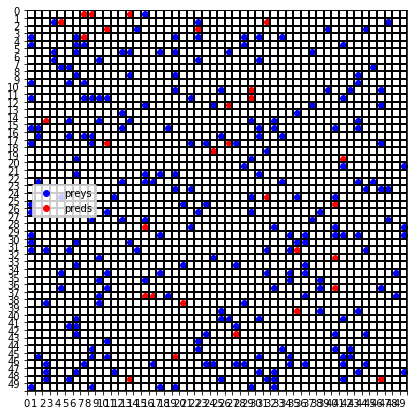

[-1.09919949 -2.6612151 ]
[-2.27450663 -2.69170391]
[-0.21066949 -1.336961  ]
[-1.77800313 -1.81543546]
[-3.16776088 -0.08223887]
[-4.02360578 -1.38816158]
[-0.19773378 -1.54526116]
[2.92498598 3.85098191]
[-2.39992497 -3.80846971]
[ 2.18973048 -0.53588428]
[-0.29538584  0.37509942]
[2.77737236 1.4460099 ]
[-2.22796496  1.13574875]
[-5.26933759  1.73515328]
[ 1.8888196  -1.58537875]
[-0.66355624  0.60408715]
[-1.34101815 -2.64020287]
[0.04127823 1.34874742]
[ 0.8650468  -0.09777024]
[-1.86575149 -1.7328239 ]
[-0.40345628 -1.79099408]
[-1.03725781  0.04214918]
[-0.98867487 -2.00246777]
[-1.4845474  -0.25432044]
[-1.84509093  1.47003728]
[ 1.23637769 -2.88901601]
[-0.27667235  0.34018698]
[-3.09136194 -3.71729245]
[ 0.29469006 -1.87135613]
[-1.81742665 -1.44336146]
[0.00912084 1.70309364]
[-1.23978682  1.20436926]
[-0.49378833  1.69579056]
[ 1.09027883 -0.62193861]
[4.13600595 2.26223635]
[-1.09713517 -2.54924265]
[-0.67587484  2.96484529]
[-1.78508578  2.93002689]
[-1.48947303  1.588518

[1.95969408 1.18900064]
[5.62818668 1.99527453]
[-0.46263775  1.08728593]
[ 1.20689477 -0.18411928]
[0.1246619  2.15723291]
[-0.42304514  0.41920804]
[0.94964302 0.15716696]
[-1.06615622 -2.85034189]
[-2.79051997  2.64381673]
[-1.13811678  1.36848743]
[1.06345542 0.66008667]
[-0.70303024  1.56797704]
[ 2.33296114 -0.90519693]
[-2.2215545   2.34482362]
[ 2.08066366 -0.26361469]
[-1.10998386 -2.12874375]
[-3.76062076 -0.60235308]
[-1.4853233  -3.35452617]
[-2.78651295 -2.8170551 ]
[2.68651183 2.48115738]
[2.1035766  0.24713071]
[-2.99978277  1.78239517]
[ 3.32338236 -0.92690158]
[-1.57745633  0.53943645]
[-1.97095791  1.48045817]
[ 2.69096977 -2.54133959]
[-3.81769187  1.44326259]
[-1.7689714  -2.45330613]
[-1.47478528  2.64016765]
[-5.14223524 -1.01522947]
[ 2.01590433 -2.82560063]
[-0.52697446  1.24057874]
[-2.61514888 -2.80617157]
[2.82865925 2.06784713]
[-2.11864575 -4.05152325]
[0.78727189 2.47885426]
[5.16368457 2.10903663]
[0.71487688 0.02695221]
[-0.200071    1.62057207]
[ 4.7892

[-1.92810543  2.55677608]
[ 1.62757727 -0.10833694]
[-0.14336978 -0.12272944]
[3.43943817 1.82967289]
[-1.40174617  0.953134  ]
[ 0.17620823 -1.54508798]
[-1.52959449  2.81338567]
[ 1.17618939 -1.80874551]
[ 5.98748626 -4.1939029 ]
[-2.07324765 -0.2499157 ]
[-5.61207943  0.39473866]
[-2.82469695 -0.15261611]
[ 1.94972566 -0.23688577]
[1.714029   1.42887085]
[-0.37171196  3.07553293]
[2.89222891 6.42524703]
[ 0.87029156 -0.39967747]
[-3.40849425 -2.09811269]
[1.10527911 2.71875956]
[-0.96644773 -0.65023629]
[3.83979885 1.95230113]
[3.68755302 2.06320212]
[-2.02889081  2.68634175]
[3.26167966 5.28574777]
[1.95442518 1.00531344]
[5.55316732 1.49089629]
[-0.52632807  2.05607448]
[-0.2368665   4.12883055]
[-0.42727994  1.69365067]
[ 0.10216544 -2.53995792]
[0.76904582 3.88459925]
[-2.26902612 -0.69223615]
[-4.00308943  2.04922696]
[-0.94153076  0.19156771]
[2.71664872e-04 1.15115314e+00]
[1.08041925 0.56526684]
[-1.28930169 -0.62878807]
[5.45519835 0.32380851]
[-2.46052078 -0.37494282]
[-1.

[ 0.19797108 -1.66597863]
[-0.49052135  1.00522537]
[ 2.77737473 -2.20212279]
[-2.24763191 -2.54835918]
[-0.25593907  2.15620372]
[-2.89038465 -2.53175913]
[-1.81478329 -2.67164618]
[0.1007406  3.81988934]
[1.70760339 5.07551055]
[-2.51441124  2.05161158]
[7.14707254 4.3569324 ]
[ 1.10541469 -2.71279748]
[ 0.95714335 -1.52055497]
[-1.11374377  1.00688695]
[-1.44481564  2.15131331]
[-0.18111074 -0.27746318]
[-4.69540419 -3.09412841]
[-0.50132131  2.70216067]
[-1.57191101 -2.68144478]
[-1.04104121  1.53154649]
[-3.99959681 -2.91785028]
[-1.83366434 -1.69364756]
[-2.07152475  0.03758055]
[0.2042426  1.62993132]
[ 2.30255042 -0.22618566]
[1.16189294 0.853826  ]
[-2.22400632  2.37197833]
[ 1.2597155  -1.53782661]
[0.53906589 4.53587032]
[-0.08499876 -0.69681746]
[ 1.00077753 -1.35804203]
[ 2.43484276 -2.46764167]
[-1.47566164  3.04922117]
[-0.53686671  0.78720013]
[ 2.86682155 -0.87841998]
[-1.30610569 -0.21110039]
[-1.88111215 -1.12908313]
[0.72288822 0.8028018 ]
[-0.84914363  0.22953633]


[-1.19507187 -0.93932574]
[0.9823908 4.4754543]
[1.80360067 2.27593695]
[3.04396666 5.22191336]
[-1.52051035 -2.75717753]
[-1.67802359 -1.28441594]
[4.60547503 3.49768081]
[-1.8716887  1.6979917]
[-2.44426985  0.61918612]
[-1.48661289  3.04296131]
[-0.10040319 -1.66397223]
[-1.47747593 -2.29901032]
[ 2.05038758 -2.07041107]
[ 2.04880268 -2.74302163]
[-0.47684653 -4.96691973]
[ 0.74300781 -0.50421822]
[-1.70481367 -1.47657201]
[-2.72341399 -2.14037542]
[ 0.40907685 -0.88951005]
[ 0.24526275 -0.19241332]
[ 1.51313435 -1.00537848]
[0.93064258 0.49515164]
[-0.83083711  2.5683694 ]
[ 1.38299201 -1.00177204]
[-0.54355931 -3.15562328]
[-1.75431304 -0.82616875]
[ 1.11057526 -0.50794328]
[-1.2271805   3.43306402]
[-2.60101186 -1.15759144]
[ 5.68408173 -0.59520667]
[3.90408098 2.34604463]
[-2.42633448  2.93572903]
[-1.81759426 -0.37688076]
[-2.23308719  2.34475044]
[0.2343193  3.42937312]
[0.99106023 0.55415983]
[1.90125307 0.24930601]
[1.40953435 2.06348429]
[-0.09095303  2.59634032]
[-1.338241

[ 1.30999063 -0.39265027]
[-1.85052974 -1.41290746]
[-0.13484878 -0.20309617]
[-0.92979226  2.71204911]
[0.64785404 3.79118489]
[-0.36565857  0.4316564 ]
[8.65471881 5.82390551]
[ 1.12708819 -1.58000756]
[0.23781843 1.30490718]
[-0.28024739  2.07966605]
[4.33553612 4.10673624]
[-2.53024873  0.32232522]
[-0.52643327  0.99237986]
[ 0.40736875 -0.10117105]
[-0.90709221  1.83474532]
[ 1.3432776  -0.48890736]
[ 0.26866922 -1.21102871]
[ 5.1115342  -2.69653461]
[-0.1756069   2.28160798]
[4.45055829 0.3026468 ]
[-0.64071471 -2.80022722]
[-0.95282679  1.11488057]
[ 6.1746947  -5.33755591]
[-0.86897609 -2.9073461 ]
[ 0.94815541 -1.80210721]
[-1.18546495 -3.1098449 ]
[-0.3090785   0.37364793]
[2.7151416  1.45721022]
[ 0.24467723 -4.58280907]
[-1.73561584 -0.46048821]
[-0.67992009 -1.8323508 ]
[-0.27437474  0.46596233]
[-2.94746756 -1.30244365]
[1.53632951 3.96597355]
[ 2.70320024 -0.02165246]
[-0.88682047  4.08271793]
[ 0.52153556 -2.35263001]
[ 2.12825004 -2.88788531]
[ 0.8884391  -1.00253318]


[ 2.94291556 -2.32650765]
[ 0.5228098  -0.21229293]
[2.36295332 1.56634945]
[-0.01041802 -2.16922767]
[1.2913991  1.83221118]
[ 4.17466637 -3.60210877]
[0.32103457 1.86229461]
[-1.14159556  1.37242537]
[-1.37497601  2.65337795]
[-1.15300628 -1.46306859]
[-0.02435991  0.08421603]
[-2.96403996  0.41026269]
[ 1.05319031 -0.06512152]
[ 1.85107181 -0.65345175]
[-3.07516871  0.49834945]
[3.55984151 0.5743531 ]
[0.89440238 1.50766808]
[3.14626815 1.37508314]
[-0.03603679  0.46718592]
[0.38257807 1.71746982]
[ 5.72624395 -2.05256839]
[ 4.32131182 -1.25416835]
[-0.51137505  0.5183456 ]
[-1.08218299 -0.50672668]
[-1.62324089 -1.98856892]
[-0.09362667  1.86314664]
[ 2.51630538 -0.39139186]
[2.55770546 4.30193256]
[-3.7393056  -1.68071585]
[2.15129591 3.48074376]
[3.09227838 0.05346949]
[ 2.35613224 -1.6221909 ]
[0.28746423 2.59769819]
[ 1.278285  -1.7735625]
[-1.97757785 -3.15544556]
[ 2.64163893 -0.39638939]
[ 2.91009078 -2.69052045]
[-4.52827133  2.07873599]
[-1.5833585 -2.7549619]
[ 1.45353501

[-2.70054485 -2.35154495]
[ 2.59415749 -0.69675338]
[-0.45101543  1.20837197]
[ 2.01085867 -4.58120461]
[ 1.7254692  -2.10024018]
[ 2.07552526 -0.73541243]
[ 0.00733624 -1.97342046]
[0.44855336 7.78494442]
[1.46527038 2.84766242]
[-1.92013506  3.7559339 ]
[-2.77158281  2.13887059]
[0.22110002 2.32952509]
[ 2.52906122 -1.38227665]
[ 0.56577031 -3.01756759]
[-2.7179207   2.74152272]
[0.2992974  1.36407165]
[-0.03918538  0.1365655 ]
[0.84086889 2.42408919]
[ 1.36031797 -0.9447584 ]
[ 0.23830058 -1.27811453]
[-0.72251621 -1.14585351]
[-1.82220645 -2.41574988]
[-0.90831981  3.83766446]
[1.8914365 2.0487541]
[0.01707946 3.11055937]
[1.0642273  1.09570235]
[-2.34378392  0.26235563]
[-2.53284308  0.41395089]
[-0.77751516  2.33285592]
[-0.06914844  0.17996559]
[-0.83097864  1.33392604]
[ 1.49593913 -1.47224981]
[3.46158145 0.11485233]
[1.02803654 0.68169758]
[3.94456443 0.84139496]
[ 1.94349101 -0.96943616]
[ 0.62186779 -0.43974822]
[-0.60363987 -3.97919393]
[3.97613375 1.01305939]
[ 0.51136075

[1.21717134 2.96365672]
[-0.15503061  0.51593839]
[-0.08908008 -3.79333155]
[4.02226074 3.15144146]
[ 0.52099378 -2.2815031 ]
[ 3.11799347 -1.90075476]
[ 0.85466899 -1.032886  ]
[-2.12855268 -2.66183609]
[-1.69718747 -1.81797333]
[9.07099118 0.735239  ]
[9.36149486 2.31123317]
[1.82454569 1.2087053 ]
[1.17457496 0.94609268]
[2.56951532 1.2898406 ]
[16.47915049 10.27208016]
[1.66312179 0.95126723]
[-1.39189565 -0.74258416]
[0.0656006 1.0817882]
[-0.12108382  1.10493224]
[0.03029447 0.32151752]
[-0.33603702 -2.14105153]
[1.63041328 2.36293627]
[-0.96610311  4.58016442]
[-0.67818757 -0.61857821]
[-0.38969293 -1.34074986]
[-0.94939762 -2.82647115]
[ 0.5523925 -2.2882772]
[ 2.15743905 -0.9224834 ]
[2.69732667 5.43617037]
[1.87766322 1.83830975]
[ 4.20164527 -6.37264751]
[0.74667506 1.58749873]
[ 0.24803076 -0.73130488]
[-2.79403497 -1.0534821 ]
[ 1.38309476 -3.53354495]
[3.28651489 2.00970785]
[1.22880182 3.6952701 ]
[ 2.5333587  -1.64143531]
[1.5274663  0.19078316]
[ 2.28320741 -0.60175823

[ 3.31049122 -2.46106677]
[-8.51655737 -1.78045451]
[-6.79679563 -3.71956385]
[ 3.05729807 -1.45256284]
[0.60955953 1.91305019]
[-2.67878193 -0.28276928]
[-2.96135125  0.61100338]
[2.9633602  6.49390664]
[-1.22456969 -5.8417456 ]
[2.24646028 1.94323709]
[-1.34513402 -1.57776389]
[ 1.8934726 -1.9127169]
[-0.56974674 -1.13441843]
[-2.32522564 -2.38446379]
[-0.03613803 -1.15987137]
[-1.76820027  2.10182662]
[2.52909357 6.10887734]
[-2.26653636 -0.13716304]
[ 1.46861997 -0.85362617]
[-0.23227621  0.27621071]
[-0.38970903 -1.00434212]
[ 4.38888305 -4.44904092]
[-1.36112488  2.98380683]
[ 1.1566913  -0.76296491]
[-1.6257192  -3.23048759]
[-0.72376701 -1.0887517 ]
[-1.47368788 -3.8872988 ]
[-1.94679561 -0.94915803]
[-3.07642509  6.2193306 ]
[-5.35070915 -1.1453235 ]
[4.27511241 2.42584491]
[-0.62983405  1.58013977]
[ 0.50164168 -1.96920702]
[-1.69904034  1.59687764]
[-13.21216783  -3.05140489]
[-5.06260914 -0.61926048]
[0.61956981 0.12070953]
[ 0.98159043 -0.53750735]
[ 3.7314867  -3.04178451

[14.56559571  6.15348444]
[ 1.35301483 -3.07405705]
[-1.45621136 -3.86503355]
[2.1052854 2.8164904]
[5.88757361 0.04430232]
[-1.78427821  0.31710467]
[-0.19038019 -1.25383881]
[2.28952874 2.45198539]
[ 6.36247941 -4.50907397]
[ 0.81653274 -1.07973281]
[12.55451724  0.35938955]
[0.96013428 5.67513428]
[-1.42305388 -0.7236531 ]
[0.27474453 3.26602894]
[5.44896198 4.56268526]
[-4.52222861 -1.34288971]
[-4.43540975  4.80299809]
[-0.66207513 -1.92648861]
[-2.40656657  1.63086978]
[-1.14272205  4.67505404]
[1.86015028 1.06209215]
[ 1.17374965 -0.65113501]
[-2.7644645   3.30284007]
[-4.42408865 -0.97686107]
[ 0.27348073 -2.6476017 ]
[-2.16105906  4.70381408]
[-0.41022756 -2.58861406]
[-2.2470624  -0.30283428]
[-1.92366123  2.95490417]
[2.61555649 2.63663063]
[ 1.14199774 -3.28247697]
[-0.96193203 -3.06739184]
[-0.7316318   1.04017235]
[ 2.73383772 14.32114642]
[1.13003363 3.76440766]
[ 2.04502873 -0.44310896]
[-1.08105658  4.0476365 ]
[ 2.84214437 -0.32981796]
[4.54824479 1.81249224]
[ 0.0120

[ 7.62357445 -0.45839933]
[ 0.874053   -0.62315406]
[ 6.85242169 -6.51309168]
[-2.61190665  6.4250979 ]
[ 2.48574014 -0.96195684]
[11.89393076  0.06837753]
[ 2.38963593 -3.86532382]
[ 8.69810021 -2.15420345]
[-0.57861388  0.26745193]
[2.69180297 1.9745868 ]
[3.37312385 2.91820372]
[6.90638614 4.61336188]
[1.65858721 3.13552267]
[ 2.62927197 -2.49028029]
[5.38956451 0.11190091]
[-8.4431794  -3.60523636]
[-8.30171387  9.80471616]
[ -2.12327997 -14.76139204]
[ 0.23127694 -1.61133931]
[ 6.38876638 -0.74982867]
[ 1.75834153 -1.41379616]
[-1.84715137  3.30266501]
[-0.8294059  -0.61836559]
[-0.25584071  6.68746516]
[ 5.56328542 -2.04558421]
[-3.04575971 -3.06657851]
[ 2.58466571 -0.39676247]
[-4.81049023  3.94723913]
[-1.06370813  0.06300244]
[0.42540568 5.2297098 ]
[-3.39278811  7.7245023 ]
[-1.77872999 -0.46538102]
[3.66690497 3.43349052]
[-0.18595143  0.69970119]
[ 1.38283519 -0.66454565]
[-1.69525097 15.85569957]
[ 4.37605819 -6.09266131]
[5.15496142 1.35258728]
[-4.80058279 12.67065973]


[4.45645158 1.43451324]
[6.12721542 1.63672985]
[ 4.86936658 -1.68545871]
[3.18983407 0.31821636]
[-2.57321645 -0.41742515]
[-1.13395204  1.60172814]
[-0.39351621  5.50717676]
[ 0.27837634 -0.30349357]
[ 4.19336279 -1.82236557]
[ 2.8925384 -0.4685246]
[-0.90986841  4.39087137]
[ 0.87520063 -2.76280078]
[ 5.13355807 -6.90909032]
[ 2.56080038 -1.50267575]
[1.42206308 4.13170052]
[4.51880359 1.98179839]
[3.65070566 2.9932372 ]
[ 0.52106785 -1.42181709]
[-1.32120303 -1.89525188]
[1.30093018 0.07765567]
[-0.97196296  2.73100674]
[-7.0757413   0.16112789]
[ 3.51962394 -1.9345234 ]
[-0.33647126  0.77729558]
[2.55048691 6.51537924]
[ 0.32493933 -0.9040185 ]
[2.05387537 0.20833386]
[2.99175393 1.45313831]
[0.90048731 1.65126272]
[ 3.04963152 -1.51600485]
[-3.68713213  4.80592343]
[-4.26594261  4.59613655]
[4.33724665 0.54958202]
[3.72005698 1.0031105 ]
[1.00679862 3.38313698]
[-9.97445664 -9.09789905]
[ 0.25305362 -2.04130586]
[0.97391756 0.48464059]
[-1.0298291  -1.08254956]
[-1.29635766  3.26

[-0.499421    5.95863977]
[ 2.29705893 -0.97543129]
[-1.06255098 -1.56207098]
[ 0.90099519 -0.07578008]
[4.82268304 1.3370412 ]
[ 4.10480581 -2.24819309]
[ 1.1450485  -1.24817472]
[2.28388524 9.38237892]
[ 0.03255219 -1.45318109]
[0.49221425 2.49225647]
[ 1.50774528 -0.61609343]
[ 2.42863579 -1.16732959]
[-2.40504659 -2.31838294]
[-3.24670644  2.30158903]
[2.38133764 1.04499144]
[0.97202262 3.77846559]
[ 5.53290501 -2.05766802]
[-1.52475775  7.85308485]
[ 5.00538122 -0.79429087]
[ 3.78514159 -2.12259555]
[ 4.42077179 -5.14366003]
[0.05830361 2.08205915]
[  9.82697588 -16.61982169]
[3.0929781  0.69837219]
[4.63430119 5.31224513]
[ 0.55015721 -0.66690348]
[-4.5269763   2.92319609]
[ 2.26758799 -0.98347686]
[ 1.55227912 11.23548706]
[9.63003925 7.59038403]
[-2.05153125 -1.11477753]
[-0.76473015 -1.95254028]
[1.23917885 6.06773567]
[-0.17465463  1.88039544]
[1.41314812 1.1278112 ]
[3.00842339 0.40440469]
[-1.06635166  9.91418619]
[1.42309266 2.18103989]
[6.19023192 7.17058043]
[1.00256497e

[0.83182826 0.70346985]
[-1.16294467 -1.45774905]
[-1.70368098 10.09393131]
[-0.87746863 -3.25426964]
[  0.78085901 -14.63318549]
[0.94958422 4.42801296]
[-9.2488053  9.5449921]
[2.3597815 2.5722258]
[ 4.09923131 -1.11811093]
[-0.15152373 -1.04538799]
[ 1.4796446  -2.75017561]
[-0.88449165  5.62631034]
[1.5791143  3.48749784]
[ 2.92593789 -2.8241017 ]
[-0.05966765 -0.09075413]
[ 4.93096058 -0.41144943]
[ 6.23094572 -1.97771507]
[-0.58970093 -2.25894176]
[3.92931693 2.91549077]
[ 0.54179172 -1.67950565]
[-1.7855297 -8.2417732]
[-1.03761492 -1.12059988]
[-1.51702648 -3.69768869]
[58.17870168 34.36128599]
[-2.27837369 -4.51011302]
[-0.85268785  1.32323342]
[-5.01495585 -8.52090512]
[ 5.98132016 -0.41715553]
[ 2.98519077 -1.42082096]
[ 2.40986754 -0.75505387]
[ 5.86789473 -4.47819253]
[-3.10723796  3.83192973]
[-0.97950279 -2.5031685 ]
[1.61835433 3.14142978]
[7.25890993 1.62569144]
[ 5.21948728 -0.08470528]
[ 0.50902303 -2.17712339]
[2.61355138 0.89407947]
[-0.22192621 -0.74977139]
[-1.64

[-1.99236179 -0.30320528]
[-1.80682872  2.52806834]
[ 3.15238133 10.84631352]
[-0.66497103 -2.62453672]
[2.16142046 1.32856378]
[1.58485958 2.68834208]
[-1.31642642  3.84471069]
[1.01338732 1.21382216]
[-2.30208766 -0.81288993]
[1.55842548 1.06552739]
[2.62667725 1.64439485]
[2.44915311 1.02602562]
[-1.07196896  1.89208732]
[5.3968723  2.50256487]
[3.68919004 2.14315117]
[15.29350474 -4.39219841]
[-0.70530611 -0.02031973]
[-0.86923279 -1.01033334]
[1.49639237 6.1210809 ]
[-2.1667578  0.5073428]
[3.26073798 1.33222308]
[-3.28899957  0.82827584]
[ 5.21182729 -6.66029329]
[ 4.40556235 -1.33156123]
[ 0.97323147 -0.63799612]
[-3.89182034 -1.58568974]
[-0.95445183  2.29036774]
[6.13860771 1.01012713]
[17.18639735  0.67825567]
[1.73093988 2.15466631]
[1.59029292 4.82037745]
[ 2.79337638 -0.46942364]
[-13.41438953  -0.43933942]
[13.04628448  4.30148653]
[12.03088778  3.13512368]
[ 7.08782735 -1.25059512]
[ 0.68172506 -1.40567298]
[ 1.62323645 -0.35608687]
[-1.21637607  1.13345642]
[-2.33954279

[-1.4428626  0.1120121]
[1.2383726  5.17306802]
[5.57458789 0.48788257]
[2.84600366 9.42717295]
[-8.63637223 -9.23616485]
[-0.59795665  3.05597977]
[1.21500007 1.27754988]
[ 0.21622312 -0.24732048]
[14.70708906 -0.53091372]
[3.06456592 8.18597358]
[ -8.97545777 -10.33788476]
[-0.23631245 -3.18659646]
[ -8.97472742 -10.33621156]
[0.7677846  6.34432806]
[ 1.10951505 -1.60754784]
[6.67595549 8.11975751]
[ 3.75399039 -1.82608759]
[ 4.0558181  -1.08071256]
[ 0.39755854 -1.07427941]
[-0.2961949  -2.99264513]
[-1.73457853  1.11795947]
[ 4.44598841 -0.84885657]
[14.1792353   1.64507601]
[3.93036217 2.29031569]
[ 3.57725661 -2.43171599]
[ 2.96473297 -0.84610214]
[10.03636271  0.13485714]
[ 1.61218694 -1.44880355]
[ 5.92134642 -2.22215979]
[ 4.81951071 -2.53513996]
[ 3.78381442 -3.35736191]
[5.7379147  4.68178048]
[-0.26530879 -0.66625057]
[9.98840854 1.575595  ]
[ 3.73321951 -1.23797274]
[ 1.91796578 -0.09173169]
[-0.50845442  3.04503026]
[ 0.21026443 -6.74390134]
[ 4.9070572  -2.54061575]
[ 1.

[ 5.10228314 18.36430189]
[11.1520628  -0.51962225]
[5.76606329 4.77905488]
[1.82113182 1.94076218]
[ 0.02227727 -0.4766037 ]
[-0.39442315  2.0608943 ]
[ 1.33726297 -0.63866243]
[0.36597874 2.13487358]
[ 0.11894682 -0.70761968]
[-4.08522846  5.35616564]
[0.73213518 1.04427777]
[ 4.31979732 -1.93501115]
[3.52786838 5.0396646 ]
[ 2.23290209 10.94857158]
[3.21658595 0.41386694]
[4.65849535 9.61478441]
[-0.59770192  2.54810156]
[ 2.76575455 -6.04293603]
[4.174735   2.79630089]
[ 0.53253874 -0.92120866]
[-1.04694501  3.8864001 ]
[ 4.01029054 -0.35660397]
[ 5.42988968 15.36890762]
[ 7.63603716 -1.81462324]
[8.70745106 1.68369248]
[ 4.89302684 -1.25074224]
[1.73023256 1.23854288]
[0.7518658  0.86938879]
[-2.1385663  -1.21553748]
[ -4.11374595 -10.19164103]
[ 9.92560827 -0.40931389]
[ 1.68635482 -0.59104696]
[ 2.31040747 -2.12729977]
[7.15920497 0.97449292]
[0.45798276 2.09487083]
[3.72586703 2.92384265]
[-0.81881369 -1.18292666]
[ 5.2443657  -0.13839958]
[-0.79408763 -1.22786574]
[-0.32588468

[ 1.8102412  -2.44435298]
[ 5.66236157 -2.72731393]
[-0.56445047 -1.13939695]
[1.87572671 1.82048542]
[ 2.81991503 -6.99651603]
[ 3.26604775 -1.8460527 ]
[1.16245155 1.57163307]
[-4.04975186  5.73269042]
[-6.3623854   1.07868252]
[-0.68436171  1.85099626]
[3.14146873 8.67409478]
[10.25496043  1.04506456]
[1.67009677 1.09181044]
[10.17286596  6.66097181]
[ 1.43788375 -0.16000653]
[ 2.32648905 -1.32143047]
[-0.36135646 -1.8573135 ]
[15.3282289   7.03661304]
[ 6.9647498  -6.06213365]
[4.27651501 9.72537877]
[3.54462829 4.15543535]
[-6.77435665 -1.63438392]
[2.87264554 2.92156299]
[ 1.39300758 -1.72934635]
[ 6.26390931 -2.24498151]
[-2.03521467  6.6051989 ]
[-2.02337323  6.73570909]
[  0.43899793 -12.59420135]
[-2.06589434  6.96318512]
[16.28620876  5.02894295]
[8.44951277 0.54763402]
[10.29413278  3.30095593]
[-0.24184777  1.861527  ]
[8.74092166 2.73441653]
[2.11400126 4.31302845]
[6.64371211 5.23396739]
[-0.57191905  5.84908489]
[-2.42306783 -2.56544081]
[-4.99798513 -0.14288051]
[-0.83

[-0.95859596  2.32358705]
[-0.04924748  2.49606317]
[  2.0193979  -11.18499183]
[16.04544071  5.26269346]
[ 1.65487364 18.33345708]
[13.28345546  0.37053767]
[ 1.47499931 -6.88443068]
[ 4.43169502 -4.86992831]
[22.25395029  0.93169585]
[ 3.39023724 -5.35192474]
[18.54699976 -0.7262192 ]
[ 4.90255787 -1.42440397]
[-3.333456   -2.58062113]
[3.09187535 1.43887563]
[ 3.67046341 -4.73539078]
[-0.20591968  1.82769195]
[-0.28356278  1.91458709]
[6.77929155 1.80667926]
[-0.48531662 21.95642771]
[-1.11403894 -4.02913839]
[0.95196855 1.70208975]
[2.03734441 0.00808304]
[ 0.32007564 18.05407413]
[-2.1775449  -2.50524022]
[-2.76775924 -1.22448498]
[ -0.87543327 -19.10027654]
[1.33778069 6.62765325]
[7.119404  7.8875448]
[ 2.81288722 -9.39445051]
[ 2.97769842 -2.47067279]
[-1.40121411 -0.68292921]
[-2.33465913  5.43034503]
[-12.53080354 -24.89202204]
[28.33805173 16.97707687]
[ 4.57283758 -0.54849227]
[5.77932989 2.85751449]
[ 3.65119344 17.10406989]
[ 0.62306626 -0.15042473]
[0.17921172 2.86584905

[3.79327055 3.28573492]
[12.35793374 -2.08643324]
[10.9807798   1.26065531]
[ 7.17129578 37.07636779]
[-1.87570345  2.59012142]
[0.58453831 4.76389741]
[0.12939229 3.5624891 ]
[8.26476953 0.84605267]
[ 2.34812557 -2.68311094]
[2.28085044 0.8988772 ]
[-13.10943773 -14.43503566]
[6.70520777 1.86419011]
[ 5.10595492 -0.12563046]
[-2.16561496 -2.13218561]
[-2.82790378 -0.64043811]
[-0.72012954 -2.93996401]
[-0.17954224  2.87345918]
[-7.65533028  1.26989577]
[1.51310481 2.68860446]
[0.39692117 3.67945677]
[ 6.40252999 -1.15908661]
[ 1.47913061 12.30676047]
[6.94764818 0.10666818]
[-3.73766238 -4.35892145]
[ 2.25193955 -2.46022493]
[ 0.91800416 -0.51542564]
[ -9.50343256 -15.18906931]
[11.24323999  1.92893276]
[3.55022982 0.5608994 ]
[ 4.78707018 -0.88350538]
[1.10616759 2.43398284]
[-2.00085253  6.23503879]
[ 4.72230262 -0.35501486]
[ 4.88242138 -0.77960733]
[-0.48312706 -2.21315491]
[-0.59452704 -2.274342  ]
[ 0.38554794 -2.15643944]
[-2.63345498  3.21498095]
[16.59016138  0.80574927]
[ 1.

[-0.41455487  0.03732368]
[12.07674712  1.15886676]
[2.72763486 9.72161143]
[-0.97680048  2.21354703]
[  0.98261694 -19.24145488]
[  0.77350597 -20.77924078]
[0.58785169 2.32061799]
[ 4.91257745 -0.68761853]
[-1.89261818e+01  1.17973125e-02]
[-8.04619009  4.12262144]
[ 4.59930364 -1.35471045]
[-0.93446548  0.23643122]
[4.2904089  1.92601209]
[ 3.83723079 -0.00665818]
[-4.11269408  1.1455935 ]
[-1.43860664 -4.66563449]
[ 1.27209999 11.29857879]
[24.98922683  2.30513293]
[-1.05709482  0.10414093]
[ 7.77638363 -2.49064624]
[1.57923119 4.03356776]
[15.82333648  3.42991851]
[ 0.32701517 -0.51505923]
[ 4.53757477 -3.01950432]
[2.33183204 6.04997244]
[ 3.63585396 11.89255965]
[11.97734328 -0.51642338]
[1.83061013 4.10106941]
[0.68041066 0.0852382 ]
[ 5.66590232 -1.43540086]
[5.5588414  1.90037995]
[2.71830584 2.73222848]
[ 3.14770758 -1.79823888]
[-0.61420488 -1.70780082]
[0.45475612 2.13378148]
[ 5.08498374 11.07767584]
[ 0.54134327 14.15473798]
[ 0.53546886 -0.87977267]
[14.01767656  1.1615

[2.77542504 1.15330969]
[-2.60627493  3.33752616]
[ 3.03200319 13.16037125]
[58.8124379  38.57437527]
[16.8181434   7.05010927]
[23.51975583 14.7207711 ]
[-21.99059627 -17.53305791]
[ 3.26673954 -3.36081446]
[1.78178846 1.72262794]
[3.14011058 5.27034668]
[-1.19165253 10.29140887]
[ 2.93519156 -0.12063793]
[ 4.82986237 -0.77158816]
[-2.33751748 -0.40427878]
[ 2.61074091 13.07444215]
[-4.7933707  -8.59161791]
[  3.080334   -14.54012719]
[6.25090831 2.49543168]
[ 4.40615694 -0.8959219 ]
[5.71878179 1.19373812]
[-3.04727055 13.77560969]
[3.71344346 0.28381198]
[ 6.4532146  -0.45361559]
[ 5.7649798  -1.63031956]
[-3.12363097  7.69207533]
[ 3.3665623 -0.2972077]
[-1.36827532 -0.34757268]
[6.73488677 2.71025335]
[-0.73450538 -2.63958765]
[-1.26306792 -0.09859096]
[8.16279035 0.15631617]
[-1.80990566 72.50593241]
[2.0494964  5.79316174]
[2.20291294 1.91120271]
[-3.06150404  0.11598473]
[ 2.52988527 -7.71704596]
[1.96387238 2.75445098]
[-0.97081184  1.12822454]
[ 11.95518217 -30.58133775]
[0.7

[-0.03661858 10.80211593]
[-2.02169572  7.5610987 ]
[-3.28409803 -5.08500954]
[7.47292112 8.2319663 ]
[ 0.05428686 -2.3780741 ]
[-0.03388645 -0.65491723]
[-2.9368921  -0.17467859]
[-1.05013146  8.73305886]
[-1.35030873  4.64841719]
[-9.52751742  7.9407069 ]
[-2.42911875 -0.48354687]
[15.42343751  4.132358  ]
[3.64204497 5.19513993]
[19.89093137  0.25026022]
[ 1.43257525 -4.67197407]
[-2.63450071 -6.11821797]
[16.56042153 -2.64554456]
[3.61678257 7.39010791]
[ 3.28684252 -1.6190311 ]
[12.02300454 12.68401777]
[ 3.9829559  -3.66848712]
[ 6.45899444 -1.52391241]
[ 4.90598062 -2.15371532]
[6.06308234 6.85840119]
[ 7.69817769 16.45651733]
[0.30197999 8.40304145]
[ -0.73998541 -18.65138003]
[ 7.87491278 -2.95352355]
[ 5.02779047 -2.95687257]
[  0.08910184 -15.06196692]
[15.4570262   5.32909791]
[-4.90361488  8.31630852]
[1.97007581 9.39458959]
[-0.79600246 -7.03125404]
[ 7.23234047 -2.83900428]
[1.76391246 3.33566785]
[1.09195021 5.36290691]
[-0.65970741 11.30992632]
[-3.57628562 42.52484455

[7.50937237 2.87974133]
[17.99224503  3.62540766]
[16.65111125  2.48718805]
[9.11812678 4.38241033]
[3.89098258 0.53440974]
[56.40670758 32.10704588]
[2.26874181 2.05592436]
[ 3.07540705 -2.00856323]
[ 3.96075432 -2.50516699]
[ 3.18123204 -0.67954419]
[29.44480606 10.26042484]
[ 3.09924724 -5.91677564]
[10.4043955  1.7718152]
[-4.04306625 10.11620267]
[4.85264766 1.63484677]
[ 6.54812942 -0.64394789]
[-13.833209    -2.55815887]
[-12.05164855 -12.93315991]
[ 3.58252532 -5.45689095]
[-8.49536545  0.92998832]
[-1.39486148 19.85780512]
[ 2.23685543 -1.46067717]
[ 3.16161519 15.11610562]
[ 2.18783913 -2.62199414]
[ 7.21196891 -6.33351251]
[-1.00510587  8.76063731]
[22.64210553 13.86813774]
[-7.32853838  1.05325523]
[19.95859748  0.83469597]
[ 7.30587011 -0.36349077]
[16.96982075  6.95197266]
[0.27701862 5.71942133]
[ 0.13074829 -2.44200921]
[  3.40390468 -11.91356284]
[23.86047104 -1.47408757]
[9.66451635 2.97606407]
[ 0.37489463 10.23050564]
[5.02717898 3.55765246]
[ 6.63839321 -0.83732948

[3.76273227 8.45461544]
[-0.43435383 -7.47360199]
[11.26633802  6.17451563]
[ 4.79685073 -8.02448814]
[3.71523482 4.78125106]
[ 1.60835212 -2.47217796]
[14.11086116 -0.80268988]
[10.76708224  0.91289147]
[11.8925978  -0.50220299]
[-4.69407953 36.92389719]
[ 3.7364414  23.15751557]
[9.72382643 9.87376868]
[ 2.18464256 43.12353795]
[17.71400738 10.19518273]
[-15.7545101 -33.8556172]
[  0.80904173 -13.71269612]
[ 4.65113317 -4.15001357]
[5.05445847 9.95555783]
[ 5.75056819 11.29745702]
[-1.23812243 -8.06323369]
[-3.39391351  3.83375398]
[-2.72141334 19.09479682]
[ 3.74388873 -0.41689798]
[ 11.8004543  -26.51582859]
[ 12.8027597  -28.43892058]
[-0.33650905 -1.01798407]
[0.68530831 3.35172065]
[ 7.82014422 -9.05611652]
[-5.96706917  6.11393449]
[30.19492287  2.15485813]
[-38.28578845  -3.10484204]
[ 2.72362497 16.7918503 ]
[12.61133866 -1.64177898]
[ 3.10341729 11.2546569 ]
[6.92081978 8.23894259]
[9.25440579 7.69421604]
[ 4.70951425 -2.05246794]
[2.92268582 8.88428389]
[ 1.55812298 11.1676

[-4.38410789 -1.12620343]
[11.20901999  4.82984672]
[-2.90162568  7.15576204]
[ 9.59481115 -3.01745521]
[-9.3126979  21.68166412]
[19.1500963   3.67916621]
[16.84128692  2.77242456]
[ 5.15473623 -0.8506908 ]
[ 2.76480424 -2.15818786]
[-1.94375618  2.67802614]
[-29.42540755  55.09217862]
[ 2.66537144 17.31150975]
[ 0.44722627 19.61744642]
[28.51914442 17.43130448]
[-4.40886502 29.64138578]
[6.77774206 1.04183242]
[9.49981116 7.00923439]
[-0.64896677 -3.12472292]
[-2.42971329  1.65748031]
[11.4416564  11.03772884]
[ 4.2528498  16.23394672]
[-17.93489297  12.5023494 ]
[1.37707195 6.71698704]
[-17.31313017  48.04390788]
[103.03571652  66.20456709]
[-22.00977189  -1.35651975]
[3.34087513 1.57679798]
[ 0.25115722 17.81092013]
[2.65326807 0.85284692]
[-1.15589854 -1.53448846]
[-22.773034    17.31939463]
[ 6.16066299 22.68967368]
[ 5.12330068 14.18623093]
[-7.09321893  0.39782859]
[10.90310271  4.84402849]
[ 2.62747796 -0.59626435]
[ 1.75108445 -1.90225015]
[-0.81454197  2.79955495]
[ 4.098455

[20.6710275   1.29828951]
[ 1.54189388 -1.07204392]
[7.51087183 1.6681868 ]
[-2.57429644 -0.91170961]
[ 7.89704697 -8.53461533]
[-3.10869282  5.01782296]
[-2.40523293  2.46514112]
[ -4.34149809 -18.24945737]
[-1.52888503  6.21257497]
[29.25570002 16.43165589]
[ 6.93967068 43.35726301]
[-0.38614941 -2.15502915]
[-10.05762547   1.62536899]
[1.57642093 1.85209405]
[5.60528127 3.46457544]
[5.80463329 6.11264699]
[-1.92611214 -1.13249208]
[ 4.41209647 -1.42890684]
[-3.8224514  -0.83664095]
[ 5.93894997 -4.38756155]
[  3.44011381 -10.13455178]
[7.04137523 5.94001551]
[8.8080327  1.33581617]
[7.69339395 9.14779373]
[-3.47481822 -4.38894801]
[1.92132848 0.88225215]
[6.79270863 4.25393566]
[ 5.52703456 -2.44603641]
[5.14946545 5.71571831]
[5.37185553 3.97427099]
[-0.85146878 -7.58937086]
[-1.59655955 11.46507417]
[-20.47468164  47.01258284]
[ 0.77068163 -5.1252898 ]
[ 3.69030536 14.32659291]
[-3.15617806 -7.19638022]
[-18.10557782 -16.63742537]
[-40.81877364 -25.09023044]
[11.20168773  1.358301

[27.21055172 -0.94621531]
[35.99650976  3.60922395]
[ 1.76782809 -1.00280473]
[ 1.47382213 16.11067311]
[-0.5739014   1.22793293]
[-2.06542577 -3.30780328]
[-13.61690719   9.33080439]
[15.97232436 14.59947951]
[-22.66154067  44.32452928]
[ 0.59408432 49.54675032]
[-6.80474944 -2.47336813]
[ 22.57217049 -21.82813632]
[  4.2559467  -20.87763447]
[  4.49726881 -24.05542182]
[122.42607237  74.15712554]
[ 1.63137266 28.91003767]
[ 3.87678562 -1.31246726]
[ 3.74618886 -1.41537821]
[ 0.6475568  -2.70871867]
[10.46655787  2.94911733]
[2.37211601 9.3702204 ]
[-2.50389163 24.08479148]
[-11.27731916  -0.16478622]
[-13.95395088  -2.4874069 ]
[81.10235934 54.1275057 ]
[17.62927865 -1.14735797]
[23.21639534  6.50634345]
[ 17.27733238 -43.40856974]
[15.4082966   4.51353984]
[7.46208035 0.47168814]
[ 1.69744733 12.57863316]
[-0.78945449 23.80372856]
[-2.27075978  1.24770229]
[28.58930318 17.38927222]
[-0.12366739 14.85951706]
[50.93482271 33.20687856]
[6.96164951 0.23159411]
[6.53181273 2.16966436]
[8

[ -0.20595621 -40.18402751]
[ 7.47845565 -9.33951985]
[ 2.80241205 24.5016475 ]
[  5.46261495 -40.13960951]
[ 2.57127609 70.2588106 ]
[5.77069822 0.78022793]
[-1.87001217 26.41292199]
[ 8.1578183  16.82817068]
[16.67993285 -5.58585785]
[18.41751816  3.00740563]
[31.5683101 -2.8495841]
[-13.31408263  39.70420079]
[-1.72915907  1.55813396]
[13.7092287   0.51395791]
[ 2.12962688 39.73528627]
[ 3.05211256 12.30167179]
[ 2.80673698 11.24685844]
[17.93614877 -0.05684006]
[31.16119222 -2.39839503]
[ 9.18928467 -9.99865073]
[-6.72574351 -6.67791364]
[ 0.23385563 -0.43721491]
[19.25629398  3.12464773]
[-1.57951698 -3.41175821]
[-33.86836252  -4.07474659]
[ 12.78913274 -17.20864062]
[114.38821866  70.8945685 ]
[-2.16889272  9.4000396 ]
[18.53243248  3.12184997]
[7.32481527 0.43357231]
[5.10513413 3.13239165]
[ 3.32030429 -3.23363606]
[ 5.62662757 76.86867515]
[ 4.57769721 14.94013707]
[ 1.70020532 -2.10652613]
[ 3.96668838 -4.86521304]
[  1.39906682 -21.99394904]
[65.6098205  43.57893298]
[3.267

[ 1.14209342 71.75571365]
[-1.84886434 20.5893168 ]
[ 0.7426181  15.58782381]
[-2.45979673 -2.43904262]
[4.93105795 8.05043266]
[ 7.70708423 -1.51297025]
[15.3892275  21.28471992]
[3.5708712  1.97511151]
[14.83955887  3.59022085]
[10.11008318 36.55530297]
[48.37061854 11.79601029]
[13.27465174 -0.87852191]
[-2.14390797 39.43404531]
[30.7408211  -1.77160212]
[-1.33969126 20.07669624]
[-0.65867715 -2.14221771]
[  3.0662537  -11.40464977]
[-11.26567239  -8.04724669]
[-16.42190361  25.88545585]
[-0.65100498 16.23185145]
[-0.0023042   0.38391042]
[12.10697497  0.98322588]
[15.47474305  1.15964628]
[-3.30576645  2.71163848]
[-1.75278839 -0.51549539]
[-2.33500947  2.95573301]
[8.6801087  1.68292577]
[15.23343481  0.30847921]
[18.75306499  2.59776269]
[25.64530818 -6.73397537]
[-1.57051868 -6.06451666]
[-0.96551505  5.47477105]
[-2.19348237 19.03665396]
[16.70779633  0.20887011]
[5.7490114  9.04038696]
[ 18.71393473 -21.03200227]
[-4.57404859  2.72007529]
[-23.30821362  13.84606628]
[-19.28445

[-2.0836758  -0.67595747]
[22.97366698  2.12083816]
[9.92123011 4.17709476]
[10.18515984 -0.73337723]
[ 2.64802528 -4.93499121]
[ 0.22399081 26.57553471]
[ 5.50801    28.30955089]
[-2.96167302  5.94314983]
[ 5.44879764 20.51994804]
[37.79966146  8.33729646]
[12.66190989 -0.60615603]
[21.72447137  2.34735956]
[13.12756881 -0.05991445]
[ 0.61562173 -7.57606815]
[1.58774333e-02 2.19512791e+01]
[13.88087603  3.36976695]
[-9.73994343 -0.79097413]
[35.10396052  3.15072095]
[19.72263968  2.04221333]
[-5.18879076 18.78977034]
[24.86664108  1.7956349 ]
[39.44930476 -4.02500804]
[4.43861719 2.32363978]
[2.91064295 2.68870928]
[-0.33668107 -0.31851512]
[ 6.41333357 -4.33284527]
[  2.77665127 -33.73246654]
[-2.01921615 -0.81782989]
[29.36950487 -2.79726624]
[28.14474465 -2.76812458]
[2.86136272 2.4386762 ]
[ 7.14043807 -0.68361032]
[13.40190148  4.54016331]
[-11.68857196   7.4589113 ]
[39.159157    7.66582237]
[10.31843515 -1.18378803]
[20.88032343 42.87463448]
[10.62080416 -1.68360464]
[10.917998

[-0.29988753 28.17627607]
[  9.67197495 -33.29975006]
[-1.54366998 31.03847267]
[-2.12573953 -4.71459726]
[ 22.46830224 -42.68207379]
[  0.25023943 -38.60274177]
[-2.90261094 67.97148877]
[-0.86144222 31.32998196]
[ 8.80254308 19.68844663]
[9.948178   1.48946428]
[31.12098039  0.56528669]
[-2.68338416 23.25378209]
[7.92667489 1.57193116]
[ 0.4512752  -0.78646087]
[-20.27480735 -51.95227743]
[-3.78227891 27.82192174]
[30.20103074 -1.22056999]
[43.22176996 -0.95789849]
[ 1.21818397 -0.13480365]
[0.46761901 7.48879945]
[-2.31850427 -9.93092363]
[ 4.48681094 13.31892944]
[-1.09216473 46.09578478]
[-0.25171335 50.8053958 ]
[11.28618754  1.63078206]
[-0.8184686  12.71937685]
[1.47136307 1.07137244]
[  2.70211828 -29.39448575]
[-0.88419842 -5.93721662]
[19.63514462  0.86712597]
[59.53419017 25.89192735]
[14.24696904  0.43126153]
[-14.59470136  29.3131146 ]
[-21.19710671  28.37363275]
[15.37810338 66.81586899]
[-18.75096483 -15.48753891]
[21.42602296  2.76300302]
[ 2.70658223 24.72517722]
[58.

[13.99976695  2.74591646]
[0.64932643 1.16402677]
[ 15.456775   -15.93231098]
[69.93019318 -0.72482416]
[ 3.81730473 11.90778214]
[ 5.11440064 -0.9964402 ]
[-2.155382   21.20185752]
[ 5.69974832 14.29126566]
[ 1.41280255 -7.27521026]
[0.18502523 3.37750423]
[29.65152916 20.10600612]
[29.88998383 22.30854222]
[ 8.65601942 -5.53207563]
[1.90337959 4.16872242]
[26.91382153 -0.21696836]
[ 14.18659711 -53.4264279 ]
[ 2.12433911 -2.51750809]
[12.96983639  0.98955822]
[17.54293152 -1.62271716]
[-6.72870097 -0.16766864]
[105.60758232 -21.17184442]
[10.36236467  5.80123682]
[29.4035005  11.37141899]
[28.1480285  -1.88772693]
[32.94766497 -5.41214476]
[-5.25479966 21.9041633 ]
[50.22581912 22.25019737]
[ 8.54085861 -2.28530887]
[ 1.78996863 11.47816966]
[-0.43500877 -0.832524  ]
[-1.46610111 13.72965714]
[ -1.479091   -49.99394026]
[  2.30485517 -11.55543433]
[61.7400939  -2.10467145]
[ 0.15462123 18.95281107]
[ 0.16539986 22.79223529]
[63.86122409 19.79949725]
[-6.33042676  1.37699652]
[42.0262

[13.12648855 -6.83085189]
[6.92022456 2.40987284]
[11.7173007  2.2928826]
[-42.66884883  -8.34430128]
[-0.60707185  4.31356502]
[-15.76900208  12.35954827]
[ 1.18762983 53.39208162]
[ 3.94857679 -1.34795443]
[ 0.62034489 -7.42340082]
[22.68675527 -2.63825845]
[67.97480966 27.71775585]
[ 5.76081191 69.05070687]
[ 2.63510808 18.14190643]
[31.58263779 -2.97733542]
[-1.90800424  3.00455589]
[-9.393537   29.82562095]
[1.45357168 2.9121114 ]
[ 24.59625025 -14.42344172]
[-2.42670024 10.6410994 ]
[ 0.98329236 24.82626663]
[4.42293986 7.49547231]
[-8.58525602 -3.36510797]
[-4.37990102 22.25841829]
[27.60216121 -4.04795356]
[76.36146959 54.23570449]
[-0.9888347 -5.2270622]
[ 1.38777249 25.13760338]
[ 2.1599536 30.2157329]
[-3.91128357 -2.00539088]
[ 2.82465523 63.40871383]
[6.83320305 1.96076108]
[-1.62679956 15.04478648]
[ -4.09627972 -58.83899366]
[ 4.35574167 -2.52465027]
[-2.89036707 13.77982722]
[-22.30935108  38.02012692]
[13.61365389 32.06379713]
[16.37560105 10.46102274]
[ 10.5829139  -1

[  9.24061548 -25.74232726]
[ 1.24063883 42.54483093]
[41.77979537 13.18352725]
[61.91498267 31.72055998]
[ 7.68851234 11.44864383]
[31.43871929  1.025615  ]
[33.35391069 29.06805908]
[51.66645848  6.72956221]
[18.18448965  5.97845044]
[-1.05206814e-01  1.07152685e+02]
[ 1.35389885 10.78093149]
[11.95403229  4.78322299]
[ 1.09439192 -2.55218092]
[33.57203098 18.14255983]
[ 5.63340634 34.3902773 ]
[-1.04155218 -0.93924129]
[  2.7594278  -48.73599055]
[4.12741668 0.19848229]
[27.77216447 -6.70701748]
[30.45996171 24.93537517]
[-4.53685171 -1.6799885 ]
[  5.0072363  -12.54566669]
[  7.71337154 -60.71237854]
[-18.92631703  68.66274368]
[6.15255409 4.95894024]
[15.45757386  4.26284218]
[ 6.98329465 22.9263765 ]
[ 1.93938937 70.45903113]
[ -0.98515031 -20.16340101]
[15.14937383  0.37502416]
[ -0.96647298 -15.39841491]
[ 25.80709639 -39.35802134]
[26.14088479 35.7872035 ]
[ 8.47094537 -3.07012084]
[ 2.76249316 15.39960165]
[-1.69634125  2.94718302]
[-11.69265184  -8.93039934]
[-2.87282818 38.

[-1.01105016 71.22646042]
[-13.92239992  -0.45839468]
[52.99571702  1.28627936]
[ 8.37672619 16.59699233]
[-1.42217673 10.16079272]
[34.83296658 30.2491471 ]
[43.11531715 -3.6064571 ]
[-7.75498874  2.17599311]
[-23.89734845  26.17055647]
[11.84516472 12.7900951 ]
[-4.18145244 47.92290201]
[7.30397451 6.32487587]
[25.36497007  4.05924004]
[-7.57291325 35.82636878]
[-0.90188116 28.09591467]
[-5.38066107 -0.71920749]
[-9.8329758  -3.44414813]
[-10.87659705 -27.22521893]
[51.19359936  0.86976453]
[41.65827612  3.50476932]
[7.15691484 2.23078434]
[18.51781955 20.26232305]
[ 7.62648038 25.58231659]
[-21.94394427  47.88182877]
[34.63356949 20.96122586]
[10.41756854  1.00580624]
[  1.96714672 -14.89234195]
[-0.19354891 19.83550623]
[5.76717056 7.76437661]
[-19.98984261  16.76057446]
[20.93996206 19.74028811]
[28.40528301 -1.19834222]
[ 3.55153221 -1.97585924]
[ 0.32494927 38.62509972]
[-95.95825796   2.70332657]
[-79.66606091  -1.51013996]
[-3.04111546 -3.6867754 ]
[17.47683785 -1.92835924]
[4

[-2.73684765 24.18040481]
[ 5.40054945 24.46867116]
[ 1.68197092 36.85518905]
[29.69761437  2.00172841]
[ 1.30719479 12.68558838]
[46.3230312  48.20522819]
[-25.16975737  11.95988735]
[ 5.88982374 17.71157313]
[3.03266675 6.03090686]
[-1.60396289  0.44118417]
[ 1.01494713 -2.77908867]
[53.35491573 -0.77842476]
[-54.28018066   1.91672314]
[29.91380546 26.6188898 ]
[5.43240313 7.68110333]
[32.16617824 12.44116514]
[21.54850906  1.18758987]
[-0.22476894 23.93653786]
[ 22.6592977  -11.51826316]
[ 4.2250153  12.99315903]
[ 5.07985508 -0.53703519]
[-7.29495591 31.51759606]
[-3.64558509 -0.15644533]
[14.46770174 -3.08718976]
[-10.51368061  -4.08698637]
[  9.18927439 -16.68059468]
[-25.69674423  -7.21670851]
[25.58363654  4.30705391]
[-2.0360406  17.76315591]
[35.2797945   2.24974436]
[16.32917453  1.7076212 ]
[29.19984925  2.52997984]
[ 44.63114783 -10.09429135]
[-17.35290798   1.61743946]
[ 36.03504379 -12.48005766]
[-0.43182114 17.10718396]
[ 8.78258411 13.17257414]
[-1.95710442 -9.50235404

[  2.96859215 -26.20451604]
[ 2.01519344 -7.26143993]
[34.41366295  2.65473948]
[-45.69215479  10.69482646]
[ 9.28867402 26.15843916]
[29.98999852 25.60170604]
[-1.4550548  22.22834633]
[ 7.4176936  15.84588467]
[ 34.87195667 -20.01660026]
[53.58564791 10.84751309]
[30.51108464 22.07902703]
[28.71558291  9.16502068]
[36.51496482  5.7416725 ]
[26.03052911 14.09423022]
[ 1.77407778 20.62754388]
[7.39461687 0.51412831]
[14.97987543 -0.81417501]
[12.27969018 24.26910259]
[ 3.16978162 -0.47041185]
[ 4.24147257 -1.38488811]
[-20.97072992 -17.67325221]
[67.23782147 26.79718449]
[74.76134265 19.68298586]
[10.92602882 59.81427739]
[15.23599373 73.4081182 ]
[41.04880021 15.06616372]
[-1.21546044 -3.13442991]
[-1.14104626 27.35406642]
[-0.56160398 23.32026873]
[ -2.10602038 -52.8993767 ]
[74.48336532 43.29137464]
[49.51499931 23.09141789]
[ 2.0775997  -3.62107994]
[  9.93358933 -19.4302918 ]
[ 1.42292773 21.66846393]
[ 2.18948851 -3.05332007]
[23.35345822 20.80154131]
[ 13.30151545 -44.26187943]


[15.17915577  0.32330612]
[ 7.06559728 38.1714601 ]
[-4.93373719 -1.04196135]
[ -8.41720475 -18.0155894 ]
[54.55588813  0.38485511]
[21.97157579 -1.0800363 ]
[0.67192595 4.68830634]
[17.88191685 -2.31190883]
[-4.89863832  2.59752727]
[36.69405045 10.65315582]
[-2.12850977e-02  8.46925592e+01]
[-1.60624558 17.79991353]
[22.18609086 41.21637631]
[-2.0566353  36.78307922]
[33.40181027  0.54526294]
[-1.16336916  6.53833542]
[ 4.45192055 37.28508662]
[ 9.6885516  -0.26423513]
[69.40558692 11.53203923]
[13.9303004  -4.39690907]
[24.33518828 -0.6973955 ]
[59.47702631 28.84773413]
[10.15701218 38.44001241]
[ 1.9492082 86.5828015]
[-13.99221182  29.79875947]
[-13.35766791 -14.56087162]
[ 2.61061999 -4.91886424]
[20.48877681  3.92822106]
[29.2829173   2.41017234]
[17.54099121 72.43086996]
[1.72093064 5.7460142 ]
[12.83567268  2.88188122]
[45.365872   -4.21776597]
[68.47349953 37.28391162]
[12.56073365 21.47045682]
[ 1.12405913 -1.74944539]
[45.0549127  25.40367154]
[23.53161065 -0.20961855]
[ 0.

[1.4093233  4.16268431]
[-31.88453853  -9.41575459]
[  0.95629403 -35.21354426]
[29.28479146 35.14560905]
[-4.64255636  9.74179713]
[32.78873804 51.80606655]
[  5.32368484 110.67331968]
[4.6344486e-02 4.9337884e+01]
[10.98830919 47.22741741]
[51.34472627  1.26166712]
[2.17800585 1.59398052]
[18.59889742 -0.73345641]
[-2.03763691  6.858241  ]
[-26.00798849  90.53216499]
[28.75971707  3.59252095]
[ 1.9493933  12.13278693]
[29.89424903 -3.4344632 ]
[47.443326   -1.65472084]
[6.71954407e+01 4.11684165e-02]
[-4.91529356  2.21304436]
[-6.57951301  1.27550184]
[25.10442042  3.4481011 ]
[-13.1458949   -7.54437697]
[26.04968395 14.63928407]
[0.76506797 2.47054526]
[41.14847195 -1.05688388]
[18.81192522 93.16879954]
[-26.3660299  266.98861527]
[ 43.3116702  -31.38774503]
[47.25547614 16.21657851]
[113.94423842  -2.71526062]
[ 6.72804506 88.64185409]
[40.83526254 -2.81281646]
[34.75307815  2.76630451]
[-2.30566027  3.43034204]
[ -0.40904749 -44.58428894]
[ 10.35134578 -33.55797743]
[12.17273829 1

[-4.53938502 23.93356603]
[ 2.10300384 -3.50834436]
[-1.77671631  1.92109498]
[-10.2296074   62.63482517]
[-23.24749636  41.49057043]
[ 60.15793448 -20.88663864]
[ 2.87258935 50.80031222]
[-26.76427818  -3.48585127]
[-43.00102507  25.99637632]
[-1.21509342 21.41953142]
[-9.60757525  2.44430096]
[ 14.43966229 -31.73339419]
[102.37116953  -1.5209099 ]
[ 0.52639667 56.22177628]
[-0.06217457 -1.93433212]
[-10.44927522  23.90763998]
[18.47381897 -2.24554703]
[-9.39252169 -7.02505725]
[-18.3906082   10.61536927]
[12.73749557  9.46446053]
[ -2.82285935 105.17599248]
[ 1.68011842 59.42339406]
[123.55600726   2.24537668]
[ 0.77512891 -1.68914889]
[62.86654411  2.96175755]
[-118.28548943   -3.0980655 ]
[-23.66926526  -0.66498115]
[0.64568615 3.09166579]
[ 10.96403017 -12.53627924]
[-7.85217277  1.50694682]
[-2.46157484 -8.26061181]
[-6.87385912 17.88964519]
[  1.68044972 -31.7704019 ]
[ 5.30069832 16.86135629]
[ 6.66472759 13.11967358]
[  2.92282481 -29.59480163]
[-2.4339941  -8.17753969]
[-5.97

[ -6.27222312 -30.7692748 ]
[ -1.17525852 -25.15882484]
[166.03490504  -1.5685032 ]
[-2.3871584  62.87578018]
[39.16489167 -2.30698776]
[-30.42688421  38.41126856]
[43.8375893  -1.74631852]
[-0.45894835 26.65709551]
[26.02324397  1.44890168]
[-11.3692282  -70.88406285]
[ 2.10497176 25.63374081]
[89.43318096 -2.56874676]
[ 1.97943859 44.08496767]
[55.81162384 -5.22260255]
[2.75047873 0.3730706 ]
[20.29590194 75.44722519]
[-4.29156189 47.45147686]
[-63.4738851  195.20469592]
[ 11.73350427 -42.60766377]
[ -9.01735897 123.11229081]
[-2.12291021  3.42128488]
[30.2923117  -4.62263733]
[15.40433305 10.36411155]
[-15.08602102   2.0084146 ]
[-17.26942092   0.76513703]
[17.34329511 36.21238726]
[ 0.37330963 55.98370413]
[  2.75138974 -73.69758509]
[23.73087738 -7.14954908]
[15.80926398  5.4213055 ]
[ 1.59113436 50.734019  ]
[ 25.40912795 -15.42525148]
[20.37684243  1.03215792]
[ 5.75257442 14.17079524]
[12.49275739  3.1567484 ]
[-40.0042175   71.20292402]
[116.0880438   -0.11683526]
[-0.25323659

[30.19990184 42.72198428]
[20.92213729  0.8304583 ]
[ -3.73756694 102.20283279]
[38.45206016 25.26894312]
[44.20193138 58.08688734]
[44.64768106 -0.54943337]
[107.04206516  64.25555715]
[-0.03010247  2.29614525]
[-37.11206473   0.7712895 ]
[ 1.80757367 -6.0164504 ]
[17.36774154 53.91543718]
[ 0.62755727 10.33081117]
[68.28190548  1.32290835]
[ -2.82234464 104.71581387]
[45.11887047 18.19239119]
[ 93.15645518 -47.47241579]
[26.96165007 45.00608239]
[40.73322439 18.73458058]
[73.83189609 29.98070228]
[-66.27323075  20.62663225]
[-13.00186052  71.87452485]
[ -1.15697296 -51.64411099]
[ 0.34856777 -4.77134404]
[-2.217965   41.23728622]
[-21.08970806  57.18140054]
[-1.16047911e+01 -9.35289027e-03]
[61.33591184 -3.07252233]
[61.49926663 37.85598649]
[-10.04143032   2.2248845 ]
[ 62.01238538 -67.63858056]
[ 47.96824073 -37.905417  ]
[ 29.55094335 -20.8411364 ]
[ 2.1061779  63.83095329]
[ 5.29799091 -0.284431  ]
[-1.78281466 -5.68536022]
[ 47.16203004 -15.09145516]
[ 9.43091975 38.71472095]
[4

[ 0.70730663 59.06308751]
[-2.0538608  17.07982396]
[ 4.64000182 10.70112793]
[-7.52978914 20.94007865]
[ 0.75957269 85.60043465]
[ 1.5406307  12.89450167]
[-110.99377651    1.25033382]
[104.31810381  37.11381942]
[-0.28426743 59.74389242]
[-0.64494483 90.72910467]
[115.3569119   -8.61694635]
[22.78859127  2.22281338]
[71.30562801 -1.94861258]
[ 2.03124831 26.83089429]
[39.50551102  0.90493479]
[-65.53659142   6.8262112 ]
[36.88751726 71.61494815]
[74.7832466  -1.63089901]
[ 7.93284298 42.0253046 ]
[-49.79818142 -20.6515191 ]
[ 2.5399766  55.30506773]
[-4.35268691  0.20424305]
[-7.02975329 -6.44734844]
[-2.43707563 -6.47877669]
[36.23035402 11.43623817]
[22.63012487 13.92098998]
[ 1.92799572 73.30000939]
[16.56439079 54.75009187]
[53.85349486  1.87787828]
[ 70.96665966 -20.20422376]
[ 12.14120336 -48.87735036]
[53.85397348 34.93700534]
[41.63358405 36.15672659]
[-5.13267798  9.98882765]
[-0.01883887 -7.36987192]
[26.99092237  0.17571989]
[ 2.75143399 59.65990749]
[50.46314175  1.911112

KeyboardInterrupt: 

In [165]:
fv,ival=f(np.asarray([0]*n))
lattice=PPA(sz,pv,pm,ival,preds,preys_pref,f,xover1,mutate)

prey=uniform(ival[0],ival[1],(preys,n))
prey=[pop("prey",prey[i]) for i in range(preys)]
lattice.distrib(prey)

pred=np.asarray([random.sample(list(np.arange(0,1+1/preds,1/(preds-1))), preds) for i in range(len(fv))]).T
pred=[pop("pred",pred[i]) for i in range(preds)]
lattice.distrib(pred)

lattice.vis()

for t in range(T):
    lattice.move("prey")
    lattice.breed()
    lattice.kill()

Results & Plots
====

In [ ]:
lattice.vis()
pareto_v, pareto_f=lattice.pareto()

Comments/Observations
===

References
===

1. Lecture Slides
2. Introduction to evolutionary computing
3. Xiaodong Li. 2003. A real-coded predator-prey genetic algorithm for multiobjective optimization. In Proceedings of the 2nd international conference on Evolutionary multi-criterion optimization (EMO’03). Springer-Verlag, Berlin, Heidelberg, 207–221.
4. Deb, K.: Multi-Objective Optimization using Evolutionary Algorithms. John Wiley & Sons, Chichester, UK (2001). 